In [1]:
import math
import random
#Benötigte Pakete

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import seaborn as sns
from scipy import stats
from decimal import Decimal

import matplotlib.mlab as mlab
import numpy as np
import cmath

from numpy import linalg as LA
import scipy
from scipy import spatial
import time
#import tables

import os
#import h5py

from matplotlib import animation
import matplotlib
from scipy.optimize import curve_fit
from matplotlib import rc

import gc
import sys
gc.enable()
import copy

from mpl_toolkits import mplot3d

In [2]:
def e_func (x,L,a):
    return a*np.exp(-x/L)

def quad_func(t,a):
    return a*t**2

def poly_func(t,a,c):
    return a*t**c

def lin_func(t,a):
    return a*t

def sublin_func(t,a,b):
    return a*t**b

def fit_func (x,L,a,c):
    return a*np.exp(-(x+c)/L)

def fit_func_quad (x,a):
    return a*x**2

### Eingabe

In [3]:
number_atoms=5           # anzahl atome
a = 100                  # fläche für erzeugte atome  a->x achse
r_b = 5                  # constraint rydberg blockade
coupling_constant= 100   # stärke der nachbarwechselwirkung
coords=[];

### Erzeugung

In the following function "produce_atoms" the arrangement of the atoms will be produced completely randomly:
Parameters are number of the atoms, the radius of the plain, Rydberg blockade and a 2D array "vorher", which could be a previous arrangement. If we don't need a previous arrangement, we hand over an empty array.

In the functions hexagonal and square a lattice is produced, either hexagonal (densest packing) or square.

In [4]:
def to_ind(coord):
    x_shifted = coord[0]+radius
    y_shifted = np.abs(coord[1]-radius)

    j = np.floor(x_shifted/(size_square))
    i = np.floor(y_shifted/(size_square))
    return int(i),int(j)

def to_coord(ind):
    x = ind[1]*size_square
    y = ind[0]*size_square
    
    x_shifted = x -radius
    y_shifted = radius - y
 
    return [x_shifted, y_shifted]


def get_atoms_near(punkt, counting_atoms):
    m,n = to_ind(punkt[0])
    atoms_near=[]
    atoms_near.extend(counting_atoms[m][n][1])

    try:
        atoms_near.extend(counting_atoms[m+1][n][1])             
        atoms_near.extend(counting_atoms[m+1][n+1][1])       
        atoms_near.extend(counting_atoms[m][n+1][1])
        atoms_near.extend(counting_atoms[m-1][n-1][1])        
        atoms_near.extend(counting_atoms[m-1][n][1])
        atoms_near.extend(counting_atoms[m-1][n+1][1])
        atoms_near.extend(counting_atoms[m][n-1][1])
        atoms_near.extend(counting_atoms[m+1][n-1][1])
        return atoms_near
    except IndexError:
        if m+1<number_squares:
            atoms_near.extend(counting_atoms[m+1][n][1])
            if n+1< number_squares:
                atoms_near.extend(counting_atoms[m+1][n+1][1])
        if n+1<number_squares:
            atoms_near.extend(counting_atoms[m][n+1][1])

        if (m-1)>=0 and (n-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n-1][1])
        if (m-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n][1])
            if n+1<number_squares:
                atoms_near.extend(counting_atoms[m-1][n+1][1])
        if (n-1)>=0: 
            atoms_near.extend(counting_atoms[m][n-1][1])
            if m+1<number_squares:
                atoms_near.extend(counting_atoms[m+1][n-1][1])
    return atoms_near


def produce_atoms(number_atoms, a, r_b):
    global size_square
    global number_squares
    size_square = 2*r_b #np.sqrt(density*50*r_b**2)   #2*r_b   #wähle size_square so, dass 50 atome drin sind.
    #size_square gerade klein genug um 8 Felder außen rum zu benutzen um abzugleichen
    number_squares= int(a*2/size_square)
    size_square = a*2/number_squares
    
    
    A=np.pi*a*a
    
    
    counting_atoms = [[[0,[]] for i in range(number_squares)] for i in range(number_squares)]
        
    atoms = [[0,0]]
    m,n = to_ind([0,0])
    counting_atoms[m][n][0]+=1
    counting_atoms[m][n][1] = [[0,0]]
    
        
    for i in range(number_atoms-len(atoms)):
        r=(a-r_b)*np.sqrt(random.uniform(0,1))
        theta=random.uniform(0,1)*2*np.pi
        x,y=r * np.cos(theta), r * np.sin(theta)
        punkt = np.array([[x,y]]) 
        gesetzt= False
        
        while (gesetzt==False):
            gesetzt=True

            atoms_near = get_atoms_near(punkt, counting_atoms)

            if atoms_near:
                if ((np.min(scipy.spatial.distance.cdist(atoms_near, punkt, metric='euclidean')))<(2*r_b)):
                    r=a*np.sqrt(random.uniform(0,1))
                    theta=random.uniform(0,1)*2*np.pi
                    x,y=r * np.cos(theta), r * np.sin(theta)
                    punkt = np.array([[x,y]]) 
                    gesetzt=False
                            
                    
        atoms.append(punkt[0])
        m,n = to_ind(punkt[0])
        counting_atoms[m][n][0]+=1
        counting_atoms[m][n][1].append(punkt[0].tolist())

    return np.round(atoms,4)


def hexagonal(r_tmp,r_b):
    atoms =[]
    spalten=math.ceil(2*r_tmp/r_b)

    x=-r_tmp
    y= r_tmp
    s=-1
    for i in range(spalten):
        for j in range(spalten):
            if np.sqrt(x*x+y*y)<(r_tmp):
                atoms.append([x,y])
            y-=2*r_b
        x+=np.sqrt((2*r_b)**2-r_b**2)
        if s >0:
            y=r_tmp
        else:
            y=r_tmp-r_b
        s*=-1
    return np.array(atoms)


def square(r_tmp,r_b):
    atoms =[]
    spalten=math.ceil(2*r_tmp/r_b)

    x=-r_tmp
    y= r_tmp

    for i in range(spalten):
        for j in range(spalten):
            if np.sqrt(x*x+y*y)<(r_tmp):
                atoms.append([x,y])
            y-=2*r_b
        x+=2*r_b
   
        y=r_tmp
     
    return np.array(atoms)

### Wahrscheinlichkeitsberechnung

In the following we calculate the distances for each pair of atoms and calculate the Hamiltonian withit.

In [5]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
    global eigenvectors2
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    eigenvalues, eigenvectors = LA.eigh(H)
    eigenvectors2=copy.copy(eigenvectors)
    #print("Time for Linearisierung: ",time.time()-start)
    
    
    #print(sys.getsizeof(H))
    H=None
    return eigenvalues, eigenvectors

In the following the time_evolution is done. We receive a three dimensional array "probability".
The first entry gives different times. And then we have in the columns the probability to find the excitation on the different atoms. (But acutally it's symmentric)

In [6]:
def ultimate_justeins(eigen_values,eigenvectors,times_tmp,angeregt):
    
    total_steps=len(times_tmp)
#Zeitenwicklung--------------------------------------------------------------------------------------------
    #start = time.time()
    projection=eigenvectors[angeregt]
    psi_t= np.zeros((total_steps,number_atoms,1),dtype="complex64")
    for i,t in enumerate(times_tmp):
        psi_t[i]= (eigenvectors @ (np.exp(-1j*eigenvalues*t)*projection))[:,None]
        
    #print("Time for Probability_Zeitentwicklung: ",time.time()-start)
    
    #komplette Zeitenwicklung ohne Schleife, aber leider langsamer:
            #psi_t2= ((eigenvectors*np.exp(-1j*eigen_values*times_tmp[:,None])[:,None])@projection)[:,:,None]
    
    
#Wahrscheinlichkeiten---------------------------------------------------------------------------------------
    #start = time.time()
    np.square(np.absolute(psi_t,out=psi_t),out=psi_t)    # now psi_all_t = probability
    #print("Time for Probability_wahrscheinlichkeit: ",time.time()-start)

    probability=np.real(psi_t)
  
    psi_t = None
    gc.collect()
    
    
    return probability

The function Berechnung gets an array with all times to calulate and breaks this array down into time intervals, which the given PC is able to calculate. For too many time steps one gets a memory error.

In [7]:
def Berechnung(eigenvalues,eigenvectors,number_atoms,time_array):  
    
    probability = np.zeros((1,number_atoms,1))
    anzahl_steps_möglich =  math.floor(1000000000/(number_atoms*number_atoms))
    # Restriction for each PC for how many time steps it can handel
    
    global runden
    ang_anzahl_steps=round(len(time_array))
    runden = math.floor((ang_anzahl_steps-1)/anzahl_steps_möglich)
    print("Von ",time_array[0],"s bis",time_array[-1],"s mit", ang_anzahl_steps," steps")
    print("Maximal mögliche Anzahl an Steps auf einmal:",anzahl_steps_möglich )
    print("Anzahl Wiederholungen:",runden)
    
    start=time.time()

    for i in range(runden):
        times_tmp = time_array[i*anzahl_steps_möglich:(i+1)*anzahl_steps_möglich]
        print("round ", i, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
        
        prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
        probability=np.append(probability,prob_tmp,axis=0)
    
    times_tmp = time_array[runden*anzahl_steps_möglich:]
    print("round ", runden, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
    prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
    probability=np.append(probability,prob_tmp,axis=0)
        
    print("Berechnung:", np.round(time.time()-start,3))
       
       
    probability=np.delete(probability,0,axis=0)
                         
    return probability

### Evaluation - Transport

In the function "auswertung" all quantities regarding to the actual transport are calculated.
Proabability accumulation, mean displacement, steady state density distribution and so on

In [8]:
def auswertung():
     
    f = open("files/probability.npy","rb")
    probability= np.load(f)
    
    
    #Expectation value - Scwerpunkt--------------------------------------------------------------------------
    erwartung= np.dot(np.transpose(probability,axes=(0,2,1)),atoms_array)  
    
    
    #abstand von Schwerpunkt --------------------------------------------------------------------------------
    abstand_schwerpunkt=np.subtract(erwartung,atoms_array)
    norm_schwerpunkt= np.sqrt(np.einsum('ijk,ijk->ij',abstand_schwerpunkt,abstand_schwerpunkt))
   
    #d_schwerpunkt_norm= np.einsum('ijk,ij->i',probability,np.square(norm_schwerpunkt))

 
    #Abstand zw. Schwerpunkt und Ursprung -----------------------------------------------------------------
    erwartung_ursprung= np.subtract(erwartung[:,angeregt],atoms_array[angeregt])
    erwartung_ursprung_norm= np.sqrt(np.einsum('jk,jk->j',erwartung_ursprung,erwartung_ursprung))
    
    
    # Mean square und mean displacement---------------------------------------------------------------------
    r_2=np.dot(np.power(abstand_ursprung,2), probability)[:,0]
    r_1=np.dot(abstand_ursprung, probability)[:,0]
    
    
    #standard deviation -----------------------------------------------------------------------------------
    deviation=np.subtract(r_2,np.square(r_1))
    
    
    #infinity_time-------------------------------------------------------------------------------------
    p_infinity=np.dot(np.square(eigenvectors[angeregt]),np.square(eigenvectors.transpose()))

    
    ipr = []
    for i in range(len(probability)):
        ipr.append((1/(np.sum(probability[i][:,angeregt]**2))))
    
    p_infinity_g=np.dot(np.power(eigenvectors[angeregt],4),np.power(eigenvectors.transpose(),4))
    
    ipr_inf = 1/(np.sum(2*p_infinity**2-p_infinity_g))

    
    

    
    

    #accumulation, correlation, radial densitiy--------------------------------------------------------------
   
    n_ursprung=[[],[], [],[]] #arr = [[] for _ in range(5)]
    global n_schwerpunkt
    n_schwerpunkt=[]
    
    n_ursprung_inf=[]    
    n_intervall_inf=[]
    n_intervall = [[],[],[],[]]
    density_inf=[]
    density=[[],[], [],[]]  
    correlation=[]
    
    
    p1=probability[0][:,angeregt]
    p2=probability[20][:,angeregt]
    p3=probability[50][:,angeregt]
    p4=probability[150][:,angeregt]
    
    
    global d_r
    d_r=r_b*5
    
    for i in range(0,int(radius-d_r),d_r):
        flaeche= np.pi*((i+d_r)**2-i**2)
        
        
        n_ursprung[0].append(np.sum(p1[(i<=abstand_ursprung)]))
        n_ursprung[1].append(np.sum(p2[(i<=abstand_ursprung)]))
        n_ursprung[2].append(np.sum(p3[(i<=abstand_ursprung)]))
        n_ursprung[3].append(np.sum(p4[(i<=abstand_ursprung)]))
        n_schwerpunkt.append(np.sum(p4[(i<=norm_schwerpunkt[1])]))
        n_ursprung_inf.append(np.sum(p_infinity[(i<=abstand_ursprung)]))
  
        
        indices=np.where((distance_matrix!=0) & (i<distance_matrix)& (distance_matrix<i+d_r))
        correlation.append(np.sum(p_infinity[indices[0]]*p_infinity[indices[1]])/flaeche)

        
        
        n_intervall[0].append((np.sum(p1[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
        n_intervall[1].append((np.sum(p2[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
        n_intervall[2].append((np.sum(p3[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
        n_intervall[3].append((np.sum(p4[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
        n_intervall_inf.append((np.sum(p_infinity[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
            
        index = np.argwhere((i<=abstand_ursprung)& (abstand_ursprung<i+d_r))
        laenge= len(index)
        if laenge==0:
            density_inf.append(0)
            density[0].append(0)
            density[1].append(0)
            density[2].append(0)
            density[3].append(0)
        else:
            density_inf.append(np.sum(p_infinity[index])/len(index))
            density[0].append(np.sum(p1[index])/len(index))
            density[1].append(np.sum(p2[index])/len(index))
            density[2].append(np.sum(p3[index])/len(index))
            density[3].append(np.sum(p4[index])/len(index))
        
   
    #distribution_width---------------------------------------------------------------------------------
    
    innen=0
    distribution_width_inf=0
    tmp=copy.copy(abstand_ursprung)
    while innen<0.9:
        minimum= np.argmin(tmp)
        distribution_width_inf= abstand_ursprung[minimum]
        innen+= p_infinity[minimum]    #
        tmp[minimum]=math.inf 
     
    r_2_inf=np.dot(p_infinity,np.power(abstand_ursprung,2)[:,None])
    r_1_inf=np.dot(p_infinity,abstand_ursprung[:,None])
    deviation_inf=np.subtract(r_2_inf,np.square(r_1_inf))
    
    
    
    erwartung_inf= np.dot(np.transpose(p_infinity),atoms_array)  
    erwartung_ursprung_inf= np.subtract(erwartung_inf,atoms_array[angeregt])
    erwartung_ursprung_norm_inf= np.sqrt(erwartung_ursprung_inf[0]**2+erwartung_ursprung_inf[1]**2)
    
    

    
    inhalt=0
    global distribution_width
    distribution_width=[]
    
    for i in range(0,len(probability)):
        tmp=copy.copy(abstand_ursprung)
        inhalt=0
        while inhalt<0.9:
            minimum= np.argmin(tmp)
            kk= abstand_ursprung[minimum]
            inhalt+= probability[i][minimum][0]
            tmp[minimum]=math.inf
        distribution_width.append(kk)
    
   

        
    #daten-----------------------------------------------------------------------------------------------
    #data_loc_sites2_%i
    #data = open("files/data_loc5_%i.npy"%number_atoms,"wb")
    #np.save(data,n_schwerpunkt)
    #np.save(data,n_ursprung)
    #np.save(data,d_schwerpunkt_norm)
    #np.save(data,d_ursprung_norm)
    #np.save(data,erwartung_ursprung_norm)
    #np.save(data,distribution_width)
    #np.save(data,n_schwerpunkt_inf)
    #np.save(data,n_ursprung_inf)
    #np.save(data,distribution_width_inf)
    #np.save(data,deviation)
    #np.save(data,deviation_inf)
    #np.save(data,n_ursprung_inf)
    #np.save(data,erwartung_ursprung_norm_inf)
    
    
    return r_1,r_2, correlation, p_infinity,density, density_inf,erwartung,ipr, ipr_inf, n_ursprung, n_intervall, n_ursprung_inf, n_intervall_inf, erwartung_ursprung_norm, erwartung_ursprung_norm_inf, deviation, distribution_width, distribution_width_inf, deviation_inf, r_1_inf, r_2_inf

### Evaluation - Eigenstates

The function one_eigenstate calculates properties like the radial density for a given eigenstate.
The function participation ratio caluclates properties for the whole system, Participation ratio or level statistics.

In [9]:
def one_eigenstate(eigenstate,dr_corr):
   
    #eigenstate----------------------------------------------------------------------------------------
    
    p_eigenstate =  np.square(np.absolute(eigenvectors2[:,eigenstate]))
  
    
    #schwerpunkt------------------------------------------------------------------------------------------
    schwerpunkt= np.dot(p_eigenstate,atoms_array) 
    distanz= scipy.spatial.distance.cdist([schwerpunkt],atoms_array, metric='euclidean')[0]
 
    #correlation
    #radial density from Schwerpunkt aus des eigenstates ------------------------------------------------
    
    correlation=[]
    density_eig=[]
    max_abstand=np.max(distanz)
    
    for klein in range(0,int(max_abstand),dr_corr):
        flaeche= np.pi*((klein+dr_corr)**2-klein**2)
        indices=np.where((klein<distance_matrix)&(distance_matrix<=klein+dr_corr))
        correlation.append(np.sum(p_eigenstate[indices[0]]*p_eigenstate[indices[1]]))
        
        index = np.argwhere((klein<=distanz) & (distanz<klein+d_r))
        laenge= len(index)
        
        if laenge==0:
            density_eig.append(0)
        else:
            density_eig.append(np.sum(p_eigenstate[index])/len(index))
   
 
     
    return p_eigenstate, density_eig, correlation, schwerpunkt, max_abstand



def participation_ratio():

    p_eigenstates = np.square(np.absolute(eigenvectors2))  
   
    #inverse participation ratio ------------------------------------------------------------------------
    pr_2=[]
    for i in range(number_atoms):    
        pr_2.append(1/np.sum(p_eigenstates[:,i]**2)) 
    
    
    ratio = np.zeros([number_atoms])
    for n in range(1,number_atoms-1):
        delta_n = eigenvalues[n+1]-eigenvalues[n]
        delta_n_1 = eigenvalues[n]-eigenvalues[n-1]
        ratio[n] = np.min([delta_n,delta_n_1])/np.max([delta_n,delta_n_1])
        
    return pr_2,ratio

# Plotting

### Animation

The function "ani" returns a simulation of the the actual spin transport, as well as a a plot where one can see the probability distribution for t-> infinity. By clicking on a atom and rerunning the mean probability calculation, it is possible to excite other atoms.
ani2(atoms_array) shows a animation of the transport in 3D

In [10]:
def ani(atoms_array):
    
    f = open("files/probability.npy","rb")
    prob_angeregt= np.squeeze(np.load(f))
    p_infinity=np.dot(np.square(eigenvectors[angeregt]),np.square(eigenvectors.transpose()))
    erwartung= np.squeeze(np.dot(np.transpose(probability,axes=(0,2,1)),atoms_array))
  
    
    %matplotlib notebook
    %matplotlib notebook
    %matplotlib notebook

    
    fig, ax = plt.subplots(1,2, figsize=(13,6))
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    plt.set_cmap('jet')
    

    angeregt_x=atoms_array[angeregt][0]
    angeregt_y=atoms_array[angeregt][1]

    
    point, = ax[0].plot([],[],"x",markersize=10, markerfacecolor="red",markeredgecolor="red")
    ursprung = ax[0].plot(angeregt_x,angeregt_y,"x",markersize=10, markerfacecolor="red",markeredgecolor="red")
    time_text = ax[0].annotate('88', xycoords="figure points", xy=(0,50))
    angeregt_text = ax[0].annotate('angeregt: Nr '+ str(angeregt), xycoords="figure points", xy=(0,40))


    scat = ax[0].scatter(atoms_array[:,0], atoms_array[:,1], marker='o',s=17, c=prob_angeregt[0],
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))

    scat2 = ax[1].scatter(atoms_array[:,0], atoms_array[:,1], marker='o',s=17, c=p_infinity,
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))

    plt.colorbar(scat, label="probability",ax=ax[0])
    plt.colorbar(scat2, label="probability",ax=ax[1])
    

        
    def animate(i, scat, ):
        point.set_data((erwartung[i]))
        time_text.set_text('Time: ' + str(round(time_array[i],12))+"s" )
        scat.set_array(prob_angeregt[i])
    
        return time_text,point, scat,    # atom_text


    anim = animation.FuncAnimation(fig, animate,
                                   frames=np.arange(0,len(prob_angeregt),1),fargs=( scat,),interval=200)

    #anim.save('im2.jpg',dpi=720)

    
    #click animation-------------------------------------------------------------------------------------------
    
    coords=[]
    i=0
    def onclick(event):
        global ix, iy
        ix, iy = event.xdata, event.ydata
        print ('x = %d, y = %d' %(ix, iy))

        global coords
        coords=[(ix, iy)]

        if len(coords) == 1:
            fig.canvas.mpl_disconnect(cid)

        return
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    
    return anim




#3D animation------------------------------------------------------------------------------------------------


def ani2(atoms_array):
    
    %matplotlib notebook
    %matplotlib notebook
    %matplotlib notebook

    fig = plt.figure(figsize=(10,15))
    ax = plt.axes(projection='3d')
    #ax.set_zlim(0,1)
    ax.view_init(20, 35) 
        
    f = open("files/probability.npy","rb")
    prob_angeregt= np.squeeze(np.load(f))

    scat = ax.plot_trisurf(atoms_array[:,0], atoms_array[:,1], prob_angeregt[0], cmap='jet', linewidth=0.5,
                     norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1));
    
    def animate(t,):
        ax.clear()
        ax.plot_trisurf(atoms_array[:,0], atoms_array[:,1], prob_angeregt[t], cmap='jet', linewidth=0.5,
         norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))
 
    anim = animation.FuncAnimation(fig, animate,frames=np.arange(0,len(prob_angeregt),1)
                                   ,interval=1)
    
    return anim

### Result plots

The function plotting returns plots for all possible quantities, which are describe the spin transport itself.
Like Mean/ mean square displacement, density, distribution width...

In [11]:
def plotting():
    
    r_1,r_2,correlation, p_infinity, density, density_inf,erwartung,ipr,ipr_inf, n_ursprung, n_intervall, n_ursprung_inf, n_intervall_inf, erwartung_ursprung_norm, erwartung_ursprung_norm_inf, deviation, distribution_width, distribution_width_inf, deviation_inf, r_1_inf, r_2_inf = auswertung()
    
    x=np.arange(0,int(radius-d_r),d_r)
    
    
    fig, axes = plt.subplots(4,2, figsize=(13,10))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)
   
    
    axes[0,0].set_title("probability accumulation")
    axes[0,0].plot(x,n_ursprung[0], label="Zeit=0");
    axes[0,0].plot(x,n_ursprung[1], label = "Zeit = 20 entry");
    axes[0,0].plot(x,n_ursprung[2], label = "Zeit = 50 entry");
    axes[0,0].plot(x,n_ursprung[3], label = "Zeit = 150 entry");
    axes[0,0].plot(x,n_ursprung_inf, label="infinite time");
    axes[0,0].set_xlabel("Abstand")
    axes[0,0].set_ylabel("Wahrscheinlichkeit")
    axes[0,0].plot(x,n_schwerpunkt, label="schwerpunkt")
    axes[0,0].legend();
    
   
    axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[1,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
    axes[1,0].plot(time_array, deviation)
    axes[1,0].plot(time_array[-1]+time_array[-1]*0.25,deviation_inf, marker ="x", label="infinite time")
    #axes[1,0].set_yscale("log")
    #axes[1,0].set_xscale("log")
    #axes[1,0].set_ylim(100,10**6)
   # axes[1,0].plot(time_array[25:250],quad_func(time_array[25:250],10**11), label=r"$t^2$");
    axes[1,0].plot(time_array[25:250],lin_func(time_array[25:250],10**7.5),label=r"$t$");
    axes[1,0].set_xlabel("Zeit")
    axes[1,0].set_ylabel(r"$\sigma$")
    axes[1,0].legend();
    
                
    axes[1,1].set_title("distribution width")
    axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[1,1].plot(time_array,distribution_width);
    axes[1,1].plot(time_array[-1]+time_array[-1]*0.25,distribution_width_inf, marker ="x", label="infinite time")
    axes[1,1].set_xlabel("Zeit")
    axes[1,1].set_ylabel("Radius");
    axes[1,1].legend();
    fig.tight_layout()
    
    
    axes[2,0].set_title("Abstand zwischen Ursprung und Schwerpunkt")
    axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[2,0].plot(time_array,erwartung_ursprung_norm);
    axes[2,0].plot(time_array[-1]+time_array[-1]*0.25,erwartung_ursprung_norm_inf, marker ="x", label="infinite time")
    axes[2,0].set_xlabel("Zeit")
    axes[2,0].set_ylabel("Abstand");
    axes[2,0].legend();
    
    axes[2,1].set_title("Participation ratio")
    axes[2,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[2,1].plot(time_array,ipr);
    axes[2,1].plot(time_array[-1]+time_array[-1]*0.25,ipr_inf, marker ="x", label="infinite time")
    axes[2,1].set_xlabel("Zeit")
    axes[2,1].set_ylabel("states");
    axes[2,1].legend();
    
                
    axes[3,0].set_title("r_2")
    axes[3,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[3,0].plot(time_array,r_2);
    axes[3,0].plot(time_array[-1]+time_array[-1]*0.25,r_2_inf, marker ="x", label="infinite time")
    axes[3,0].set_xlabel("Zeit")
    axes[3,0].set_ylabel("Abstand");
    axes[3,0].legend();

                
    axes[3,1].set_title("r_1")
    axes[3,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[3,1].plot(time_array,r_1);
    axes[3,1].plot(time_array[-1]+time_array[-1]*0.25,r_1_inf, marker ="x", label="infinite time")
    axes[3,1].set_xlabel("Zeit")
    axes[3,1].set_ylabel("Abstand");
    axes[3,1].legend();
    
                
    fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)      
   
    
    axes[0,0].set_title("radial density area")
    #axes[4,0].plot(x[:len(n_intervall[0])],n_intervall[0], label="Zeit=0");
    #axes[4,0].plot(x[:len(n_intervall[0])],n_intervall[1], label = "Zeit = 1");
    #axes[4,0].plot(x[:len(n_intervall[0])],n_intervall[2], label = "Zeit = 5");
    #axes[4,0].plot(x[:len(n_intervall[0])],n_intervall[3], label = "Zeit = 50");
    axes[0,0].plot(x,n_intervall_inf, label="infinite time");
    axes[0,0].set_xlabel("Abstand")
    axes[0,0].set_ylabel("Dichte")
    axes[0,0].set_yscale("log")
    axes[0,0].legend();
    
    
    axes[0,1].set_title("radial density atoms")
    #axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
    axes[0,1].plot(x,density_inf);
    axes[0,1].set_xlabel("Abstand")
    axes[0,1].set_ylabel("Dichte");
    axes[0,1].set_yscale("log")
    axes[0,1].legend();
    
    
    axes[1,0].set_title("radial density atoms - log log")
    axes[1,0].plot(x,density_inf, label="infinite time");
    axes[1,0].set_xlabel("Abstand")
    axes[1,0].set_ylabel("Dichte")
    axes[1,0].set_yscale("log")
    axes[1,0].set_xscale("log")
    axes[1,0].legend();
    
    axes[1,1].set_title("correlation - log")
    axes[1,1].plot(x,correlation, label="infinite time");
    axes[1,1].set_xlabel("Abstand")
    axes[1,1].set_ylabel("Dichte")
    axes[1,1].set_yscale("log")
    #axes[5,1].set_xscale("log")
    axes[1,1].legend();

    return

### Plots for the eigenstates 

plot_one_eigenstate shows characteristics of a special eigenstate
plot_all_eigenstates shows properties of the whole system, like Participation ratios oder level statistics.

In [12]:
def plot_one_eigenstate(p_eigenstate, density_eig, correlation, schwerpunkt, max_abstand, dr_corr):
    
    # 3d and 2d scatter animation plot ------------------------------------------------------------------
    
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(2, 2, 1)
    ax.set_aspect('equal')
    
    scat= ax.scatter(atoms_array[:,0], atoms_array[:,1], marker='o', c=p_eigenstate, cmap = "jet",
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1*10**0))
    
    plt.colorbar(scat, label="probability", ax=ax)
    ax.plot(schwerpunkt[0],schwerpunkt[1],"x",markersize=15,markeredgewidth=2, markerfacecolor="red",markeredgecolor="red")
    
    
    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.plot_trisurf(atoms_array[:,0], atoms_array[:,1], p_eigenstate, cmap='jet', linewidth=0.5,
                    norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))
   

    ax = fig.add_subplot(2, 2, 3)
    ax.set_aspect('equal')
    
    indices= np.squeeze(scipy.spatial.distance.cdist([schwerpunkt],atoms_array, metric='euclidean')<radius*0.3)
    atoms_close= atoms_array[indices]
    scat2= ax.scatter(atoms_close[:,0], atoms_close[:,1], marker='o',c=p_eigenstate[indices], cmap = "jet",
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1*10**0))
   
    for i in range(len(atoms_close)):
        circle = plt.Circle((atoms_close[i][0], atoms_close[i][1]), radius=r_b, fill=False)
        plt.gca().add_patch(circle)
  
    

    plt.show()

    #----------------------------------------------------------------------------------------------------

    
    fig, axes = plt.subplots(2,2,figsize=(13,8))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
   
    x1=np.arange(0, int(max_abstand),dr_corr) 
    x=np.arange(0, max_abstand,dr_corr) 
    axes[0,0].set_title("correlation - single log ")
    axes[0,0].plot(x1,correlation);
    axes[0,0].set_yscale("log")
    axes[0,0].set_xlabel("Radius")
    axes[0,0].set_ylabel("Wahrscheinlichkeit")
    
   

    axes[0,1].set_title("correlation - log log")
    axes[0,1].plot(x1,correlation);   
    axes[0,1].set_yscale("log")
    axes[0,1].set_xscale("log")
    axes[0,1].set_xlabel("Radius")
    axes[0,1].set_ylabel("Wahrscheinlichkeit")
    axes[0,1].plot(x,poly_func(x,10000,-6))  
    
    axes[1,0].set_title("radial density - single log")
    axes[1,0].plot(x1,density_eig)
    axes[1,0].set_yscale("log")
    
    axes[1,1].set_title("radial density - double log")
    axes[1,1].plot(x1,density_eig)
    axes[1,1].set_xscale("log")
    axes[1,1].set_yscale("log")
    
    axes[1,1].plot(x,poly_func(x,10000,-6)) 

In [13]:
def plot_all_eigenstates(ipr,ratio,eigenvalues):
    
    
    fig, axes = plt.subplots(1,figsize=(4,4))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)
    
    axes.set_title("Level Spectrum")
    bins = np.linspace(min(eigenvalues),max(eigenvalues),50)
    axes.hist(eigenvalues,bins=bins)
    axes.ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    axes.set_xlabel("energy")
    axes.set_ylabel("#")
    
    
    
    x=np.arange(0,radius,1)   
    
    fig, axes = plt.subplots(4,2,figsize=(13,15))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)
    
    
    axes[0,0].set_title("Inverse Participation Ratio - über Energie")
    axes[0,0].errorbar(eigenvalues,ipr, linestyle="None", marker=".") ;   
    #axes[1,0].set_yscale("log")
    axes[0,0].set_xlabel("energy")
    axes[0,0].set_ylabel("Inverse PR")
    axes[0,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
          
        
        
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ipr, statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ipr, statistic='std', bins=50)
    
    
    axes[0,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[0,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data')
    axes[0,1].set_title("Inverse Participation ratio - gebint")
    axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    axes[0,1].set_xlabel("energy")
    axes[0,1].set_ylabel("Inverse PR")
    
        
    axes[1,0].set_title("Participation Ratio - über Energie")
    axes[1,0].errorbar(eigenvalues,1/ipr, linestyle="None", marker=".") ;   
    #axes[0,0].set_yscale("log")
    axes[1,0].set_xlabel("energy")
    axes[1,0].set_ylabel("PR")
    axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)   
        
        
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    1/ipr, statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    1/ipr, statistic='std', bins=50)
    
    
    axes[1,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[1,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data')
    axes[1,1].set_title("Participation ratio - gebint")
    axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    axes[1,1].set_xlabel("energy")
    axes[1,1].set_ylabel("PR")
    
    

    axes[2,0].set_title("Level Spectrum")
    axes[2,0].hist(1/ipr,bins=50)
    axes[2,0].set_xlabel("PR")
    axes[2,0].set_ylabel("#")
    

    axes[2,1].set_title("Level Spectrum")
    axes[2,1].hist(ipr,bins=500)
    axes[2,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    axes[2,1].set_xlabel("Inverse PR")
    axes[2,1].set_ylabel("#")
    
    hist, bin_edges = np.histogram(ratio, bins=500)
    axes[3,0].step(bin_edges[:-1],hist,where="post");
    axes[3,0].set_title("Häufigkeit der level spacing ratios")
    
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ratio, statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ratio, statistic='std', bins=50)

    
    axes[3,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[3,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data') 
    axes[3,1].set_title("averaged level spacing ratios")
    
    fig.tight_layout()

# Mean Execution

In [14]:
global number_atoms
global radius
coupling_constant= 3*10**9  #stärke der nachbarwechselwirkung

#Parameter:
number_atoms=1000
density= 0.5
r_b = 5
radius = (np.sqrt(number_atoms*r_b**2/density))

t1=np.arange(0,10**-7,10**-8)[:10]
t2=np.arange(10**-7,10**-5,10**-7)[:99]
t3=np.arange(10**-5,10**-4,10**-6)[:90]
t4=np.arange(10**-4,10**-3,10**-5)[:90]

global times
time_array=np.concatenate((t1,t2,t3,t4),axis=0)
#t=np.logspace(-8,-3,289)


global angeregt
angeregt=0                  #atom 0 is atom in the center


z= pow(number_atoms/(np.pi*radius*radius), -1.0/2.0)
print("Radius of the plain: ", round(radius,2))
print("Rydberg Blockade:", round(r_b,2))
print("Dichte: ", np.round((number_atoms*np.pi*r_b*r_b)/(np.pi*radius**2),2))
print("Mittlerer abstand:", round(z,2))
print()



#Configurationserzeugung -------------------------------------------------------------------------------------

#atoms_file = open("files/atoms_array.npy","rb")
#vorher=np.load(atoms_file)
vorher =[]

if not coords:           #one can choose the atom, which should be excited, by clicking on it
    start = time.time()
    atoms_array = produce_atoms(number_atoms, radius, r_b) 
    atoms_file = open("files/atoms_array.npy","wb")
    np.save(atoms_file,atoms_array)
    print("Time for Erzeugung: "+'{:5.3f}s'.format(time.time()-start))
else:
    angeregt= np.argmin(scipy.spatial.distance.cdist(atoms_array, coords, metric='euclidean'))
print("angeregt: Atom", angeregt)


#atoms_array=hexagonal(200,5)
number_atoms=len(atoms_array)

# Calculating probability------------------------------------------------------------------------------------
start = time.time()
eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)

probability=Berechnung(eigenvalues,eigenvectors,number_atoms,time_array)
f_probability = open("files/probability.npy","wb")
np.save(f_probability,probability)

print("Time for calculation: "+'{:5.3f}s'.format(time.time()-start))

Radius of the plain:  223.61
Rydberg Blockade: 5
Dichte:  0.5
Mittlerer abstand: 12.53

Time for Erzeugung: 2.629s
angeregt: Atom 0
Von  0.0 s bis 0.00099 s mit 289  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  289  from:  0.0  to  0.00099
Berechnung: 1.478
Time for calculation: 2.291s


### Animation

In [18]:
coords=[]

<IPython.core.display.Javascript object>


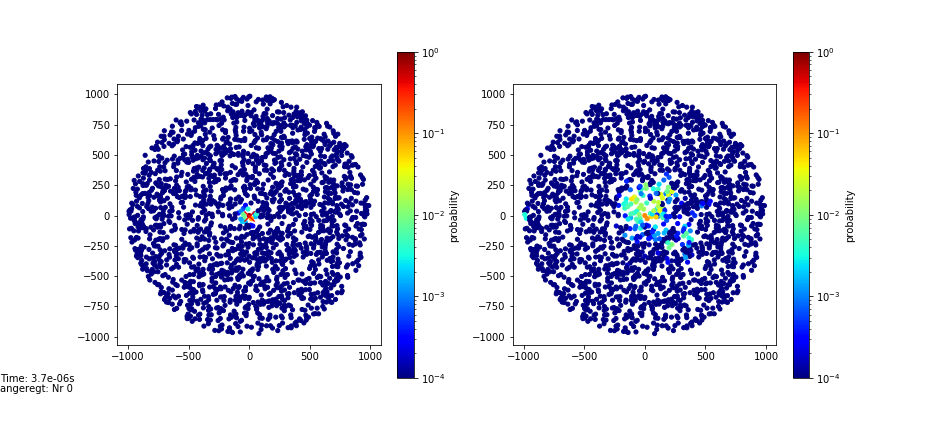

In [19]:
ani(atoms_array)

### Transport properties

Probability accumulation: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  sum of probability in circle of radius x <br>
standard deviation:      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; r_2 - (r_1)^2 <br>
distribution width:      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; radius of a circle which contains 90% of the probability <br>
Abstand Ursprung SP:      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; clear <br>
participation ratio:      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;over how many states is the excitation distributed <br>
r_2:                     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; mean square displacement <br>
r_1:                     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; mean displacement <br>
radial Density Area:             &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  sum of probability in anuli divided by the area of the anulus -> fixed width of the anulus, but calculated for every r <br>
radial Density atoms:             &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  sum of probability in anuli divided by the number of atoms in the anulus <br>

No handles with labels found to put in legend.


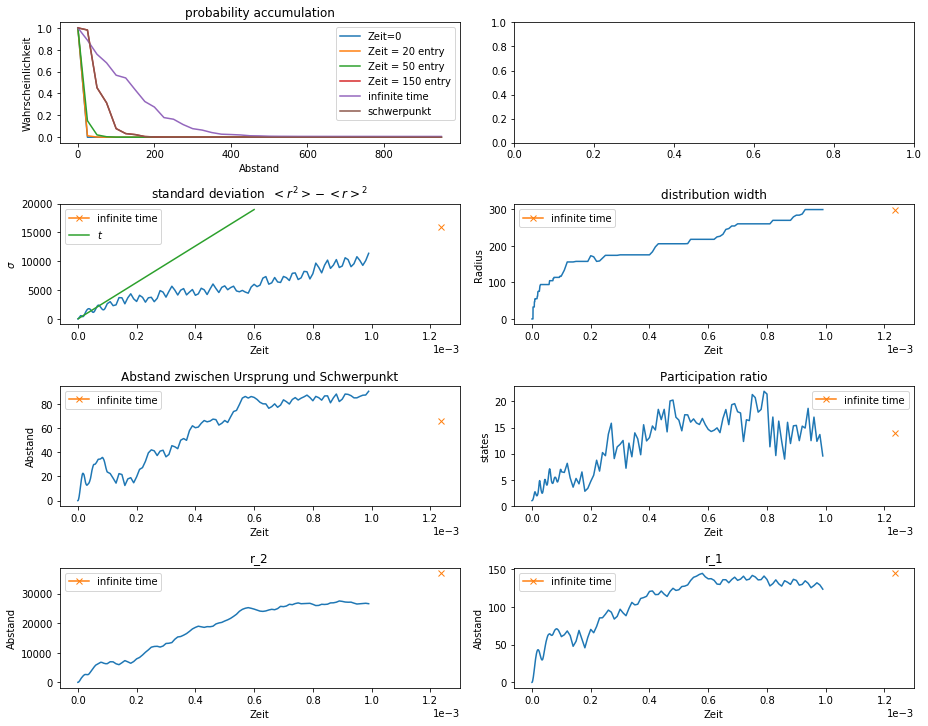

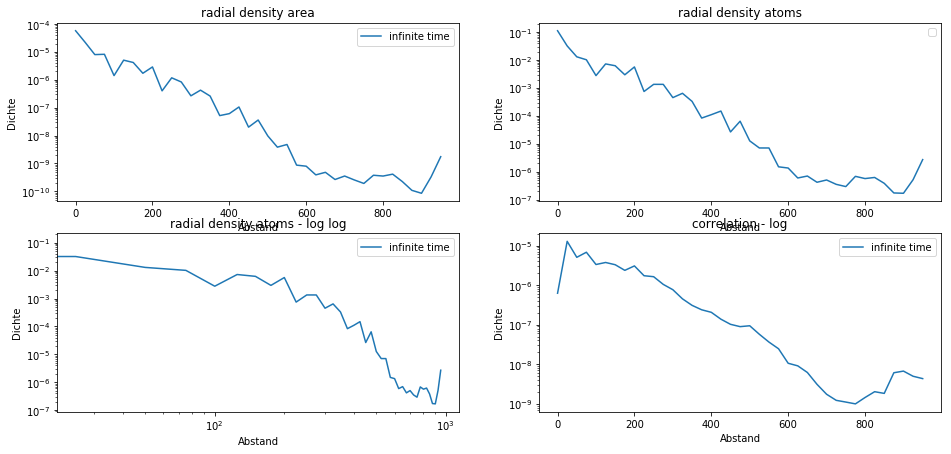

In [20]:
%matplotlib inline
%matplotlib inline
%matplotlib inline
plotting()

### Eigenstate properties

In [ ]:
number_atoms=10000
density= 0.2

radius = (np.sqrt(number_atoms*r_b**2/density))
atoms_array = produce_atoms(number_atoms, radius, r_b) 

eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)
pr_2, ratio= participation_ratio()
plot_all_eigenstates(1/np.array(pr_2),ratio,eigenvalues)

In [16]:
data = open("10000_01.npy","wb")
np.save(data,pr_2)
np.save(data,eigenvalues)

In [21]:
def find_good_eigenstate():
    
    p_eigenstates = np.square(np.absolute(eigenvectors2))  

    #schwerpunkte der eigenstates----------------------------------------------------------------------------
    schwerpunkte= np.dot(p_eigenstates.transpose(),atoms_array)
      
    #participation ratio ------------------------------------------------------------------------------------
    pr_2=[]
    for i in range(number_atoms):    
        pr_2.append(1/np.sum(p_eigenstates[:,i]**2)) 
    
   

    # Variance----------------------------------------------------------------------------------------------
    r_2=np.dot(np.power(abstand_ursprung,2),p_eigenstates)
    r_1=np.dot(abstand_ursprung,p_eigenstates)

    variance=np.subtract(r_2,np.square(r_1))

    arg_variance = np.argsort(variance)


    #find smallest participation ratio close to the center of the plain--------------------------------------
    arg_pr = np.argsort(pr_2)
    
    
    punkte=[]
    
    
    for i in arg_pr:
        punkte.append(schwerpunkte[i])
        if np.linalg.norm(schwerpunkte[i])<0.1*radius:
            break
    
    best_eigenstate_pr=i
    
    for i in arg_variance:
        punkte.append(schwerpunkte[i])
        if np.linalg.norm(schwerpunkte[i])<0.1*radius:
            break
    
    best_eigenstate_variance=i
   
    punkte=np.array(punkte)
    
    
    
    
    
    print("Number of eigenvalue: ", best_eigenstate_pr)
    print("Schwerpunkt: ", schwerpunkte[best_eigenstate_pr])
    print("Participation ratio: ", np.round(pr_2[best_eigenstate_pr],3))

    

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(punkte[:,0],punkte[:,1], s=5)
    ax[1].scatter(punkte[:,0],punkte[:,1], s=5)
   
    ax[0].scatter(punkte[-1][0], punkte[-1][1],color="red")
    ax[1].scatter(punkte[0][0], punkte[0][1],color="red")
    ax[0].set_xlim(-radius,radius)
    ax[0].set_ylim(-radius,radius)
    ax[1].set_xlim(-radius,radius)
    ax[1].set_ylim(-radius,radius)
    
    ax[0].set_title("Numbered by the actual state (eigenvalue)")
    ax[1].set_title("Numbered from smallest to highest PR")
    
    for j, txt in enumerate(arg_pr[:len(punkte[:,0])]):
        ax[0].annotate(txt, (punkte[j][0], punkte[j][1]))

    n=np.arange(0,len(punkte[:,0]),1)
    for j, txt in enumerate(n):
        ax[1].annotate(txt, (punkte[j][0], punkte[j][1]))
    
    print()
    print("PR for smallest energy: ", np.round(pr_2[0],3))
    print("smallest PR: ",np.round(pr_2[arg_pr[0]],3))
    
  
    
    return best_eigenstate_pr, best_eigenstate_variance, arg_pr, arg_variance, variance, pr_2, schwerpunkte, p_eigenstates

#### Generate new condiguration

In [20]:
number_atoms=1000 
density= 0.25
r_b = 5
radius = (np.sqrt(number_atoms*r_b**2/density))
print(radius)

atoms_array = produce_atoms(number_atoms, radius, r_b,vorher) 
atoms_file = open("files/atoms_array.npy","wb")
np.save(atoms_file,atoms_array)
eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)

316.22776601683796


Number of eigenvalue:  193
Schwerpunkt:  [-3.70893026  9.12243649]
Participation ratio:  2.144

PR for smallest energy:  6.491
smallest PR:  1.38


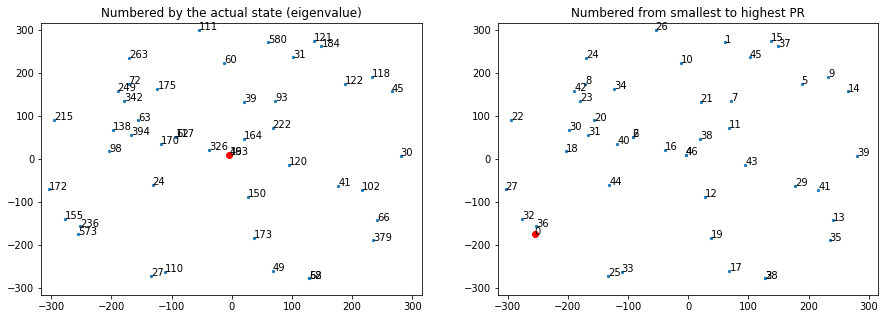

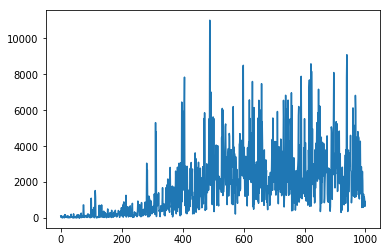

In [21]:
best_usable_pr, best_usable_variance, arg_pr, arg_variance,variance, pr_2, schwerpunkte, p_eigenstates =find_good_eigenstate()

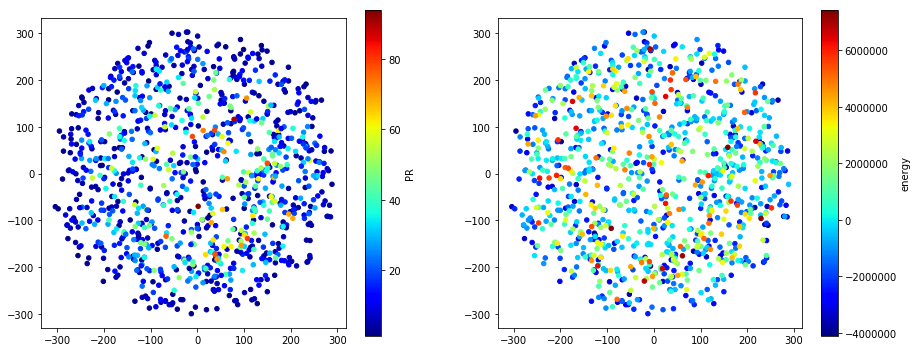

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.set_cmap('jet')
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")

scat= ax[0].scatter(schwerpunkte[:,0],schwerpunkte[:,1],c=pr_2,s=20)#norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))
scat2=ax[1].scatter(schwerpunkte[:,0],schwerpunkte[:,1],c=eigenvalues,s=20)#norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))

plt.colorbar(scat, label="PR",ax=ax[0])
plt.colorbar(scat2, label="energy",ax=ax[1]);

Probleme:
- best_usable eigenstate schon bissel zu viel ausgedehnt
- indices[0] eigenstate hat zwar kleinsten PR, aber trotzdem große ausdehnung

=> Eigenstate zu kleinster Energie am besten, weil Varianz sehr gering.
=> berechne Varianz und versuche kleinsten PR mit kleinster Varianz in der Mitte zu finden


Gesehen:
   - kleinste energy ist am besten geeignet um den gewollten Verlauf zu sehen.
        - bei hoher Dichte sieht man gut den exponentiellen Anfang
        - bei niedriger Dichte sieht man deutlich den algebraichen tail
   - umso größer wir die Dichte machen, desto länger wird der exponentielle Anfang und desto kürzer der Tail

Weitere Ideen:
- mittlerer Abstand

#### Eigenstate mit kleinster Energy

Number of eigenvalue:  0
Participation ratio:  6.491
Energy:  -4.104E+6
Variance:  114.0


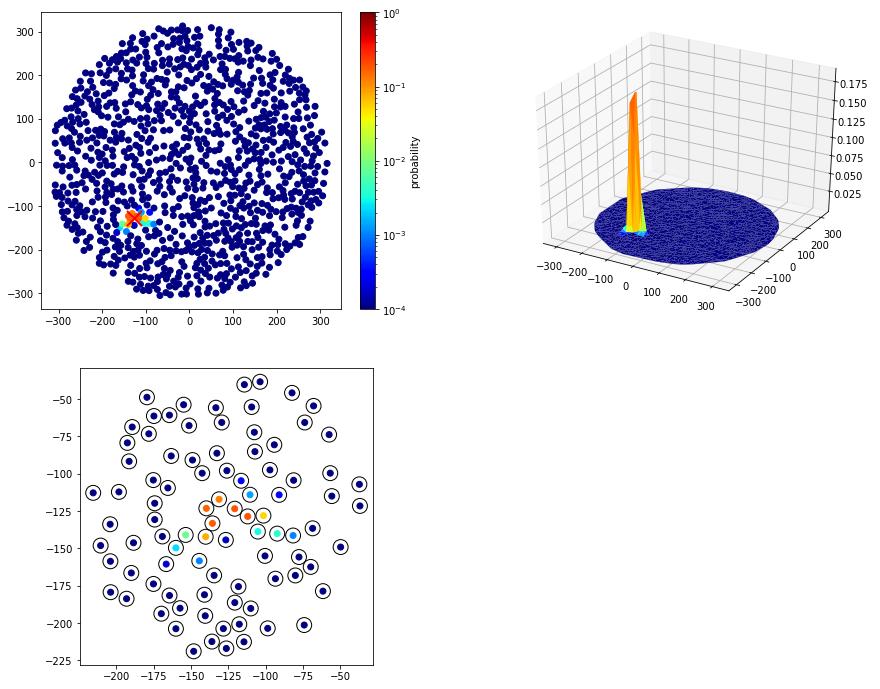

/home/jp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


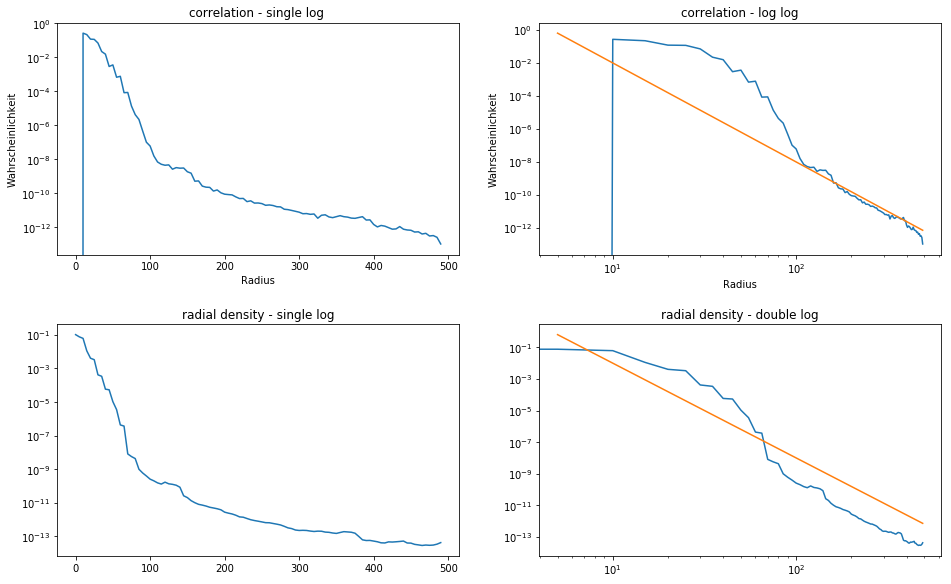

In [27]:
dr_corr=5

print("Number of eigenvalue: ", 0)
print("Participation ratio: ", np.round(pr_2[0],3))
print("Energy: ", "{:.3E}".format(Decimal(str(eigenvalues[0])))) 
print("Variance: ", np.round(variance[0],0))

p_eigenstate, density_eig, correlation, schwerpunkt,max_abstand = one_eigenstate(0,dr_corr)
plot_one_eigenstate(p_eigenstate,density_eig, correlation, schwerpunkt,max_abstand,dr_corr)
